# INFO-4604/5604 HW2: Linear Classification 
## Deadline: Wednesday, October 3, 9:00pm MT

### Solution by: *Ben Niu* (and list any partners)


## Assignment overview

In this assignment, you will build a classifier that tries to infer whether tweets from [@realDonaldTrump](https://twitter.com/realDonaldTrump) were written by Trump himself or by a staff person.
This is an example of binary classification on a text dataset. 

It is known that Donald Trump uses an Android phone, and it has been observed that some of his tweets come from Android while others come from other devices (most commonly iPhone). It is widely believed that Android tweets are written by Trump himself, while iPhone tweets are written by other staff. For more information, you can read this [blog post by David Robinson](http://varianceexplained.org/r/trump-tweets/), written prior to the election, which finds a number of differences in the style and timing of tweets published under these two devices. (Some tweets are written from other devices, but for simplicity the dataset for this assignment is restricted to these two.)

This is a classification task known as "authorship attribution", which is the task of inferring the author of a document when the authorship is unknown. We will see how accurately this can be done with linear classifiers using word features.

You will need `sklearn` version 0.19 for this assignment.

### What to hand in

You will submit the assignment on Canvas. Submit a single Jupyter notebook named `hw2lastname.ipynb`, where lastname is replaced with your last name.

If you have any output that is not part of your notebook, you may submit that as a separate document, in a single PDF named `hw2lastname.pdf`. For example, this assignment requires you to create plots. You could do it directly with python using [matplotlib](https://matplotlib.org/), but if you wanted to create them using other software, that's acceptable as long as you put all of the figures in a single document and you clearly label them with the corresponding deliverable number.

When writing code in this notebook, you are encouraged to create additional cells in whatever way makes the presentation more organized and easy to follow. You are allowed to import additional Python libraries.

### Submission policies

- **Collaboration:** You are allowed to work with up to 3 people besides yourself. You are still expected to write up your own solution. Each individual must turn in their own submission, and list your collaborators after your name.
- **Late submissions:** We allow each student to use up to 5 late days over the semester. You have late days, not late hours. This means that if your submission is late by any amount of time past the deadline, then this will use up a late day. If it is late by any amount beyond 24 hours past the deadline, then this will use a second late, and so on. Once you have used up all late days, late assignments will be given at most 80% credit after one day and 60% credit after two days.


## Getting started

In this assignment, you will experiment with perceptron and logistic regression in `sklearn`. Much of the code has already been written for you. We will use a class called `SGDClassifier` (which you should read about in the [sklearn documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)), which  implements stochastic gradient descent (SGD) for a variety of loss functions, including both perceptron and logistic regression, so this will be a way to easily move between the two classifiers.

The code below will load the datasets. There are two data collections: the "training" data, which contains the tweets that you will use for training the classifiers, and the "testing" data, which are tweets that you will use to measure the classifier accuracy. The test tweets are instances the classifier has never seen before, so they are a good way to see how the classifier will behave on data it hasn't seen before. However, we still know the labels of the test tweets, so we can measure the accuracy.

For this problem, we will use what are called "bag of words" features, which are commonly used when doing classification with text. Each feature is a word, and the value of a feature for a particular tweet is number of times the word appears in the tweet (with value $0$ if the word does not appear in the tweet).

Run the block of code below to load the data. You don't need to do anything yet. Move on to "Problem 1" next.

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

df_train = pd.read_csv('http://cmci.colorado.edu/classes/INFO-4604/data/tweets.train.tsv', sep='\t', header=None)

Y_train = df_train.iloc[0:, 0].values
text_train = df_train.iloc[0:, 1].values

vec = CountVectorizer()
X_train = vec.fit_transform(text_train)
feature_names = np.asarray(vec.get_feature_names())

df_test = pd.read_csv('http://cmci.colorado.edu/classes/INFO-4604/data/tweets.test.tsv', sep='\t', header=None)
Y_test = df_test.iloc[0:, 0].values
text_test = df_test.iloc[0:, 1].values

X_test = vec.transform(text_test)


In [3]:
text_train

array(["My statement as to what's happening in Sweden was in reference to a story that was broadcast on _USERNAME_ concerning immigrants & Sweden.",
       'Will be having many meetings this weekend at The Southern White House. Big 5:00 P.M. speech in Melbourne, Florida. A lot to talk about!',
       "Don't believe the main stream (fake news) media.The White House is running VERY WELL. I inherited a MESS and am in the process of fixing it.",
       ...,
       'Great to be back in Arizona! #MakeAmericaGreatAgain #Trump2016 _URL_',
       "If crazy _USERNAME_ didn't cover me so much on her terrible show, her ratings would totally tank. She is so average in so many ways!",
       "Crazy _USERNAME_ says I don't (won't) go on her show and she still gets good ratings. But almost all of her shows are negative hits on me!"],
      dtype=object)


## Problem 1: Understand the data [6 points]

Before doing anything else, take time to understand the code above.

The variables `df_train` and `df_test` are dataframes that store the training (and testing) datasets, which are contained in tab-separated files where the first column is the label and the second column is the text of the tweet.

The [`CountVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) class converts the raw text into a bag-of-words into a feature vector representation that `sklearn` can use.

You should print out the values of the variables and write any other code needed to answer the following questions.

#### Deliverable 1.1: How many training instances are in the dataset? How many test instances?

[2593 training instances in the dataset,185 test instances]

#### Deliverable 1.2: How many features are in the training data?

[4829 features in the training data]

#### Deliverable 1.3: What is the distribution of labels in the training data? That is, what percentage of instances are 'Android' versus 'iPhone'?

[Android = 51.63%  iPhone = 48.36]

Problem #1 

In [5]:
# Your code can go here
#Deliverable 1.1
df_train.count()


0    2593
1    2593
dtype: int64

In [6]:
df_test.count()

0    185
1    185
dtype: int64

In [7]:
np.count_nonzero(feature_names)

4829

In [8]:
df_train[0].value_counts()



Android    1339
iPhone     1254
Name: 0, dtype: int64

In [9]:
1339/2593

0.5163902815271886

In [10]:
1254/2593

0.4836097184728114

## Problem 2: Perceptron [6 points]

The code below trains an [`SGDClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) using the perceptron loss, then it measures the accuracy of the classifier on the test data, using `sklearn`'s [`accuracy_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) function. 

The `fit` function trains the classifier. The feature weights are stored in the `coef_` variable after training. The `predict` function of the trained `SGDClassifier` outputs the predicted label for a given instance or list of instances.

Additionally, this code displays the features and their weights in sorted order, which you may want to examine to understand what the classifier is learning. In this dataset, the $\textrm{Android}$ class is considered the "negative" class because it comes first in the data.

There are 3 keyword arguments that have been added to the code below. It is important you keep the same values of these arguments whenever you create an `SGDClassifier` instance in this assignment so that you get consistent results. They are:

- `max_iter` is one of the stopping criteria, which is the maximum number of iterations/epochs the algorithm will run for.

- `tol` is the other stopping criterion, which is how small the difference between the current loss and previous loss should be before stopping.

- `random_state` is a seed for pseudorandom number generation. The algorithm uses randomness in the way the training data are sorted, which will affect the solution that is learned, and even the accuracy of that solution.

Wait a minute $-$ in class we learned that the loss function is convex, so the algorithm will find the same minimum regardless of how it is trained. Why is there random variation in the output? The reason is that even though there is only one minimum value of the loss, there may be different weights that result in the same loss, so randomness is a matter of tie-breaking. What's more, while different weights may have the same loss, they could lead to different classification accuracies, because the loss function is not the same as accuracy. (Unless accuracy was your loss function... which is possible, but uncommon because it turns out to be a difficult function to optimize.)

Note that different computers may still give different answers, despite keeping these settings the same, because of how pseudorandom numbers are generated with different operating systems and Python environments. 

To begin, run the code in the cell below without modification.

#### Deliverable 2.1: Based on the training accuracy, do you conclude that the data are linearly separable? Why or why not?

[It is not linearly separable, the accuracy is not one hundred percent ]

#### Deliverable 2.2: Which feature most increases the likelihood that the class is 'Android' and which feature most increases the likelihood that the class is 'iPhone'? 

[Feature: "00" most increases the likelihood that the class is "Android" and Feature: "imwithyou" most increses the likelihood that the class is "iPhone"]

<br />

One technique for improving the resulting model with perceptron (or stochastic gradient descent learning in general) is to take an average of the weight vectors learned at different iterations of the algorithm, rather than only using the final weights that minimize the loss. That is, calculate $\bar{\mathbf{w}} = \sum_{t=1}^T \mathbf{w}^{(t)}$ where $\mathbf{w}^{(t)}$ is the weight vector at iteration $t$ of the algorithm and $T$ is the number of iterations, and then use $\bar{\mathbf{w}}$ when making classifications on new data.

To use this technique in your classifier, add the keyword argument `average=True` to the `SGDClassifier` function. Try it now.

#### Deliverable 2.3: Compare the initial training/test accuracies to the training/test accuracies after doing averaging. What happens? Why do you think averaging the weights from different iterations has this effect?

[The test accuracies decrese when compare to the initial/test accuracies ]


In [11]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score

classifier = SGDClassifier(loss='perceptron', max_iter=1000, tol=1.0e-12, random_state=123,average=True)
classifier.fit(X_train, Y_train)

print("Number of SGD iterations: %d" % classifier.n_iter_)
print("Training accuracy: %0.6f" % accuracy_score(Y_train, classifier.predict(X_train)))
print("Testing accuracy: %0.6f" % accuracy_score(Y_test, classifier.predict(X_test)))

print("\nFeature weights:")
args = np.argsort(classifier.coef_[0])
for a in args:
    print(" %s: %0.4f" % (feature_names[a], classifier.coef_[0][a]))

Number of SGD iterations: 11
Training accuracy: 0.976475
Testing accuracy: 0.886486

Feature weights:
 00: -9.9091
 badly: -7.6059
 wow: -7.3583
 into: -6.3731
 being: -5.9374
 _username_: -5.7988
 big: -5.7803
 veterans: -5.7074
 donaldtrump: -5.2672
 statement: -5.0767
 making: -5.0487
 called: -5.0485
 actually: -4.9706
 crooked: -4.8853
 talking: -4.8551
 look: -4.8299
 running: -4.8173
 trump: -4.5242
 four: -4.4426
 what: -4.3104
 reviews: -4.2824
 eric: -4.1727
 eastern: -4.1190
 call: -4.1058
 cannot: -4.0295
 own: -3.9973
 illegals: -3.9797
 used: -3.9520
 policy: -3.9443
 mess: -3.9383
 allowed: -3.9088
 sources: -3.9037
 mails: -3.8954
 expensive: -3.8680
 set: -3.7898
 talks: -3.7274
 senator: -3.7212
 strong: -3.7163
 turned: -3.7053
 mr: -3.7003
 media: -3.6838
 wrong: -3.6470
 lie: -3.6380
 said: -3.6157
 immigrants: -3.5692
 dead: -3.5629
 that: -3.5492
 politics: -3.4902
 created: -3.4614
 woman: -3.4596
 inauguration: -3.4456
 stay: -3.4041
 facts: -3.3976
 praised: -

 summit: 0.0000
 superior: 0.0000
 supporting: 0.0000
 pic: 0.0000
 photo: 0.0000
 philrobertson: 0.0000
 resulted: 0.0000
 phillips: 0.0000
 phil: 0.0000
 phenomena: 0.0000
 surged: 0.0000
 surges: 0.0000
 pertains: 0.0000
 perspective: 0.0000
 retail: 0.0000
 paving: 0.0000
 syracuse: 0.0000
 pause: 0.0000
 syrians: 0.0000
 pac: 0.0000
 owns: 0.0000
 owning: 0.0000
 teachers4trump: 0.0000
 teamsters: 0.0000
 owner: 0.0000
 teamtrump: 0.0000
 teamusa: 0.0000
 owed: 0.0000
 scandals: 0.0000
 reverend: 0.0000
 overturned: 0.0000
 overtaxed: 0.0000
 overruns: 0.0000
 technical: 0.0000
 overflow: 0.0000
 technician: 0.0000
 ovations: 0.0000
 telepromter: 0.0000
 ovation: 0.0000
 temporary: 0.0000
 scam: 0.0000
 outstanding: 0.0000
 outspending: 0.0000
 tennessee: 0.0000
 scene: 0.0000
 outperform: 0.0000
 rumors: 0.0000
 pack: 0.0000
 table: 0.0000
 tabulation: 0.0000
 patriot: 0.0000
 taco: 0.0000
 takes: 0.0000
 parts: 0.0000
 schedule: 0.0000
 parties: 0.0000
 tallahassee: 0.0000
 para

## Problem 3: Logistic regression [15 points]

For this problem, create a new `SGDClassifier`, this time setting the `loss` argument to `'log'`, which will train a logistic regression classifier. Set `average=False` for the remaining problems.

Once you have trained the classifier, you can use the `predict` function to get the classifications, as with perceptron. Additionally, logistic regression provides probabilities for the predictions. You can get the probabilities by calling the `predict_proba` function. This will give a list of two numbers; the first is the probability that the class is $\textrm{Android}$ and the second is the probability that the class is $\textrm{iPhone}$.


For the first task, add the keyword argument `alpha` to the `SGDClassifier` function. This is the regularization strength, called $\lambda$ in lecture. If you don't specify `alpha`, it defaults to $0.0001$. Experiment with other values and see how this affects the outcome.

#### Deliverable 3.1: Calculate the training and testing accuracy when `alpha` is one of $[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]$. Create a plot where the x-axis is `alpha` and the y-axis is accuracy, with two lines (one for training and one for testing). You can borrow the code from HW1 for generating plots in Python. Use [a log scale for the x-axis](https://matplotlib.org/examples/pylab_examples/log_demo.html) so that the `alpha` values are spaced evenly.

[your solution should either be plotted below, or included in a separate PDF]

#### Deliverable 3.2: Examine the classifier probabilities using the `predict_proba` function when training with different values of `alpha`. What do you observe? How does `alpha` affect the prediction probabilities, and why do you think this happens?

[As alpha becoming large, the prediction probabilities become close to 0.5]

<br />

Now remove the `alpha` argument so that it goes back to the default value. We'll now look at the effect of the learning rate. By default, `sklearn` uses an "optimal" learning rate based on some heuristics that work well for many problems. However, it can be good to see how the learning rate can affect the algorithm.

For this task, add the keyword argument `learning_rate` to the `SGDClassifier` function and set the value to `invscaling`. This defines the learning rate at iteration $t$ as: $\eta_t = \frac{\eta_0}{t^a}$, where $\eta_0$ and $a$ are both arguments you have to define in the `SGDClassifier` function, called `eta0` and `power_t`, respectively. Experiment with different values of `eta0` and `power_t` and see how they affect the number of iterations it takes the algorithm to converge. You will often find that it will not finish within the maximum of $1000$ iterations.

#### Deliverable 3.3: Fill in the table below with the number of iterations for values of `eta0` in $[10.0, 100.0, 1000.0, 10000.0]$ and values of `power_t` in $[0.5, 1.0, 2.0]$. You may find it easier to write python code that can output the markdown for the table, but if you do that place the output here. If it does not converge within the maximum number of iterations (set to $1000$ by `max_iter`), record $1000$ as the number of iterations.

| `eta0`   | `power_t` | # Iterations |
|-----------|-----------|--------------|
| $10.0$    | $0.5$     |42            |
| $10.0$    | $1.0$     |1000          |
| $10.0$    | $2.0$     |1000          |
| $100.0$   | $0.5$     |9             |
| $100.0$   | $1.0$     |1000          |
| $100.0$   | $2.0$     |1000          |
| $1000.0$  | $0.5$     |11            |
| $1000.0$  | $1.0$     |1000          |
| $1000.0$  | $2.0$     |1000          |
| $10000.0$ | $0.5$     |7             |
| $10000.0$ | $1.0$     |25            |
| $10000.0$ | $2.0$     |1000          |

#### Deliverable 3.4: Describe how `eta0` and `power_t` affect the learning rate based on the formula (e.g., if you increase `power_t`, what will this do to the learning rate?), and connect this to what you observe in the table above.

['eta0' and 'power_t' determines the learning rate. 'eta0' remains the same, increase' power_t' will decrese the learning rate.In the table, it shows the bigger the learning rate, the smaller the iteration ]
   
<br />

Now remove the `learning_rate`, `eta0`, and `power_t` arguments so that the learning rate returns to the default setting. For this final task, we will experiment with how high the probabiity must be before an instance is classified as positive.

The code below includes a function called `threshold` which takes as input the classification probabilities of the data (called `probs`, which is given by the function `predict_proba`) and a threshold (called `tau`, a scalar that should be a value between $0$ and $1$). It will classify each instance as $\textrm{Android}$ if the probability of being $\textrm{Android}$ is greater than `tau`, otherwise it will classify the instance as $\textrm{iPhone}$. Note that if you set `tau` to $0.5$, the `threshold` function should give you exactly the same output as the classifier `predict` function.

You should find that increasing the threshold causes the accuracy to drop. This makes sense, because you are classifying some things as $\textrm{iPhone}$ even though it's more probable that they are $\textrm{Android}$. So why do this? Suppose you care more about accurately identifying the $\textrm{Android}$ tweets and you don't care as much about `iPhone` tweets. You want to be confident that when you classify a tweet as $\textrm{Android}$ that it really is $\textrm{Android}$.

There is a metric called _precision_ which measures something like accuracy but for one specific class. Whereas accuracy is the percentage of tweets that were correctly classified, the precision of $\textrm{Android}$ would be the percentage of tweets classified as $\textrm{Android}$ that were correctly classified. (In other words, the number of tweets classified as $\textrm{Android}$ whose correct label was $\textrm{Android}$, divided by the number of tweets classified as $\textrm{Android}$.)

You can use the [`precision_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score) function from `sklearn` to calculate the precision. It works just like the `accuracy_score` function, except you have to add an additional keyword argument, `pos_label='Android'`, which tells it that $\textrm{Android}$ is the class you want to calculate the precision of.

#### Deliverable 3.5: Calculate the testing precision when the value of `tau` for thresholding is one of $[0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]$. Create a plot where the x-axis is `tau` and the y-axis is precision.

[your solution should either be plotted below, or included in a separate PDF]

#### Deliverable 3.6: Describe what you observe with thresholding (e.g., what happens to precision as the threshold increases?), and explain why you think this happens.

[The higher the thresholding, the higher the precision score. Because the higher thresholding classify more labels as 'Android' ,this increses the prescision socre accroding to the prescision score function(the number of tweets classified as $\textrm{Android}$ whose correct label was $\textrm{Android}$, divided by the number of tweets classified as $\textrm{Android}$) ]

In [12]:
# use this function for deliverable 3.5
def threshold(probs, tau):
    return np.where(probs[:,0] > tau, 'Android', 'iPhone')

# your logistic regression code here

alpha = [0.0001,0.001,0.01,0.1,1.0,10.0,100.0]
actrain = []
actest = []
for i in alpha:
    classifier1 = SGDClassifier(loss='log', max_iter=1000, tol=1.0e-12, random_state=123,average=False,alpha = i)
    classifier1.fit(X_train, Y_train)
    actrain.append(accuracy_score(Y_train, classifier1.predict(X_train)))
    actest.append(accuracy_score(Y_test, classifier1.predict(X_test)))

    predictions = classifier1.predict_proba(X_test)
    #print(predictions)
    print("Number of SGD iterations: %d" % classifier1.n_iter_)
    #print("Training accuracy: %0.6f" % accuracy_score(Y_train, classifier1.predict(X_train)))
    #print("Testing accuracy: %0.6f" % accuracy_score(Y_test, classifier1.predict(X_test)))

#print("\nFeature weights:")
#args = np.argsort(classifier1.coef_[0])
#for a in args:
    #print(" %s: %0.4f" % (feature_names[a], classifier.coef_[0][a]))

Number of SGD iterations: 9
Number of SGD iterations: 16
Number of SGD iterations: 5
Number of SGD iterations: 7
Number of SGD iterations: 4
Number of SGD iterations: 2
Number of SGD iterations: 2


Deliverable 3.1

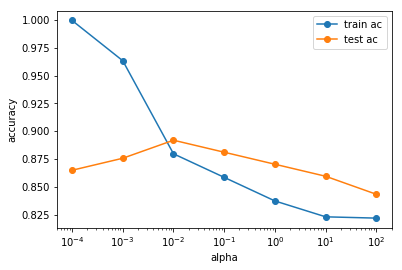

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
#plt.plot(alpha, actrain,actest, marker='o')
plt.semilogx(alpha,actrain,marker='o',label='train ac')
plt.semilogx(alpha,actest,marker='o',label='test ac')
plt.xlabel('alpha')
plt.ylabel('accuracy')
plt.legend(loc='upper right')

plt.show()

Deliverable 3.2

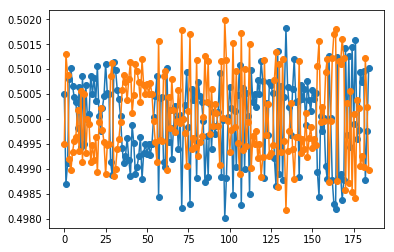

In [14]:
plt.plot( predictions, marker='o')

Deliverable 3.3

In [15]:
e = [10,100,1000,10000]
p = [0.5,1,2]
for i in e:
    for a in p:
        classifier1 = SGDClassifier(loss='log', max_iter=1000, tol=1.0e-12, random_state=123,average=False,learning_rate="invscaling",eta0 = i, power_t= a)#alpha = i)
        classifier1.fit(X_train, Y_train)

        print("Number of SGD iterations: %d" % classifier1.n_iter_)
        print(i,a)
        

Number of SGD iterations: 42
10 0.5


D:\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Number of SGD iterations: 1000
10 1
Number of SGD iterations: 1000
10 2
Number of SGD iterations: 9
100 0.5
Number of SGD iterations: 1000
100 1
Number of SGD iterations: 1000
100 2
Number of SGD iterations: 11
1000 0.5
Number of SGD iterations: 1000
1000 1
Number of SGD iterations: 1000
1000 2
Number of SGD iterations: 7
10000 0.5
Number of SGD iterations: 25
10000 1
Number of SGD iterations: 1000
10000 2


Diliverable 3.5

In [16]:
def threshold(probs, tau):
    return np.where(probs[:,0] > tau, 'Android', 'iPhone')


tau= [0.5,0.6,0.7,0.8,0.9,0.95,0.99]
pctest = []
for i in tau:
    classifier1 = SGDClassifier(loss='log', max_iter=1000, tol=1.0e-12, random_state=123,average=False)
    classifier1.fit(X_train, Y_train)
    pctest.append(precision_score(Y_test, threshold(classifier1.predict_proba(X_test),i),pos_label = 'Android'))
 

    #predictions = classifier.predict_proba(X_test)
    #print(predictions)
    #print("Number of SGD iterations: %d" % classifier1.n_iter_)
    #print("Training accuracy: %0.6f" % accuracy_score(Y_train, classifier1.predict(X_train)))
    #print("Testing accuracy: %0.6f" % accuracy_score(Y_test, classifier1.predict(X_test)))
print(pctest)

[0.85148514851485146, 0.85148514851485146, 0.84848484848484851, 0.83870967741935487, 0.84705882352941175, 0.89855072463768115, 0.90196078431372551]


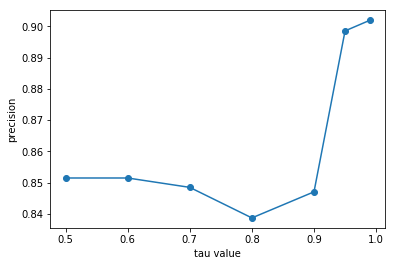

In [32]:
plt.plot(tau,pctest,marker ='o')
plt.xlabel('tau value')
plt.ylabel('precision')


plt.show()

## Problem 4: Sparse learning [5604: 5 points; 4604: +3 EC points]

Add the `penalty` argument to `SGDClassifier` and set the value to `'l1'`, which tells the algorithm to use L1 regularization instead of the default L2. Recall from lecture that L1 regularization encourages weights to stay at exactly $0$, resulting in a more "sparse" model than L2. You should see this effect if you examine the values of `classifier.coef_`.

#### Deliverable 4.1: Write a function to calculate the number of features whose weights are nonzero when using L1 regularization. Calculate the number of nonzero feature weights when `alpha` is one of $[0.00001, 0.0001, 0.001, 0.01, 0.1]$. Create a plot where the x-axis is `alpha` and the y-axis is the number of nonzero weights, using a log scale for the x-axis.

[your solution should either be plotted below, or included in a separate PDF]

In [30]:
# your code here
alpha = [0.00001,0.0001,0.001,0.01,1.0]
nlist = []
for i in alpha:
    
    classifier = SGDClassifier(loss='perceptron',penalty='l1',max_iter=1000, tol=1.0e-12, random_state=123,alpha = i)
    classifier.fit(X_train, Y_train)
    nlist.append(np.count_nonzero(classifier.coef_[0]))
    
print(nlist)
#print("Number of SGD iterations: %d" % classifier.n_iter_)
#print("Training accuracy: %0.6f" % accuracy_score(Y_train, classifier.predict(X_train)))
#print("Testing accuracy: %0.6f" % accuracy_score(Y_test, classifier.predict(X_test)))

#print("\nFeature weights:")
#args = np.argsort(classifier.coef_[0])
#for a in args:
    #print(" %s: %0.4f" % (feature_names[a], classifier.coef_[0][a]))

[2840, 1851, 46, 1, 0]


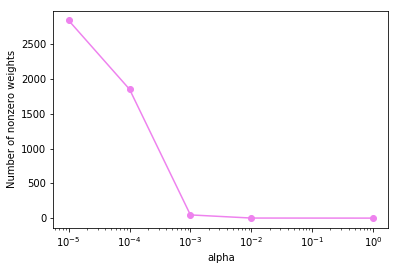

In [39]:
plt.semilogx(alpha,nlist,marker='o',color = 'violet')
plt.xlabel('alpha')
plt.ylabel('Number of nonzero weights')
plt.show()